In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import imageio
import warnings
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from keras import initializers

%matplotlib inline
warnings.simplefilter('ignore')

## Local image preprocessing

In [ ]:
simpsons = []
DIR = './simpsons_faces'

for filename in tqdm(os.listdir(DIR)):
    path = os.path.join(DIR, filename)
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((64, 64), Image.ANTIALIAS)
    simpsons.append(np.array(image))
    
np.savez('simpsons.npz', simpsons)
print(np.array(simpsons).shape)

In [ ]:
''' load image array from disk '''
simpsons = np.load('./simpsons.npz')
simpsons = (simpsons['arr_0'].astype('float32') - 127.5) / 127.5
print(simpsons.shape)

In [ ]:
init = initializers.RandomNormal(mean=0.0, stddev=0.02)
opt = Adam(lr=0.0002, beta_1=0.5)

## models

In [ ]:
''' SHALLOW MODEL @ 32-X-32 '''

# img_shape = (32, 32, 3)
# z_dim = 100
# init = initializers.RandomNormal(mean=0.0, stddev=0.02)
# opt = Adam(lr=0.0002, beta_1=0.5)

# def build_discriminator(in_shape=img_shape):
#     model = Sequential()
    
#     model.add(Conv2D(64, (3,3), input_shape=in_shape))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2D(128, (3,3), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2D(128, (3,3), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2D(256, (3,3), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation='sigmoid'))
    
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
#     return model

# def build_generator(latent_dim):
#     model = Sequential()
    
#     model.add(Dense(256*4*4, input_dim=latent_dim))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Reshape((4, 4, 256)))
    
#     model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2DTranspose(128, (4,4), strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
    
#     model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    
#     return model

# def build_gan(generator, discriminator):
#     discriminator.trainable = False
    
#     model = Sequential()
#     model.add(generator)
#     model.add(discriminator)
    
#     model.summary()
#     model.compile(loss='binary_crossentropy', optimizer=opt)
    
#     return model

In [ ]:
''' DEEPER MODEL @ 64-X-64 '''

img_shape = (64, 64, 3)
z_dim = 100
init = initializers.RandomNormal(mean=0.0, stddev=0.02)
opt = Adam(lr=0.0002, beta_1=0.5)

def build_discriminator(in_shape=img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, input_shape=img_shape, padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, (5, 5), strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1024, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
#     model.summary()
    
    return model

def build_generator(latent_dim):
    model = Sequential()
    
    model.add(Dense(1024*8*8, input_dim=latent_dim, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 1024)))
    
    model.add(Conv2DTranspose(512, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(256, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (5, 5), strides=1, padding='same', activation='tanh'))
    
#     model.summary()
    
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

## combined model

## helper methods

In [ ]:
def load_real_samples():
    simpsons_data = np.load('./simpsons.npz')
    X_train = simpsons_data['arr_0']
    
    # scale the data from the range [0, 255] to [-1, 1]
    # to work with the hyperbolic tangent
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    
    return X_train

In [ ]:
''' select real images '''
def generate_authentic_images(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    
    # generate authentic class labels (1)
    y = np.ones((n_samples, 1))
    
    return X, y

In [ ]:
''' generate points in latent space as input for the generator '''
def generate_latent_points(latent_dim, n_samples):
    z_noise = np.random.randn(latent_dim * n_samples)
    z_noise = z_noise.reshape(n_samples, latent_dim)
    
    return z_noise

In [ ]:
''' use the generator to produce synthetic images, with class labels '''
def generate_synthetic_images(generator, latent_dim, n_samples):
    z_noise = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(z_noise)
    
    # create 'synthetic' class labels (0)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [ ]:
''' plot the images '''
def save_plot(examples, epoch, n=7):
    # rescale from the range [-1, 1] to [0, 1]
    examples = (examples+1) / 2.0
    
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(examples[i])
        
    plt.savefig('generated_plot_e%03d.png' % (epoch+1))

In [ ]:
''' evaluate the discriminator, plot the images & save the model '''
def summarize_performance(epoch, g, d, dataset, latent_dim, n_samples=150):
    # prepare authentic samples
    X_authentic, y_authentic = generate_authentic_images(dataset, n_samples)
    _, accuracy_authentic = d.evaluate(X_authentic, y_authentic, verbose=1)
    
    # prepare synthetic images
    X_synthetic, y_synthetic = generate_synthetic_images(g, latent_dim, n_samples)
    _, accuracy_synthetic = d.evaluate(X_synthetic, y_synthetic, verbose=1)
    
    print('> Accuracy > authentic: %.0f%% || synthetic: %.0f%%' % (accuracy_authentic*100, accuracy_synthetic*100))
    save_plot(X_synthetic, epoch)
    g.save('generator_model_%03d.h5' % (epoch+1))

In [ ]:
''' train the generator and discriminator models '''
def train(g, d, gan, dataset, latent_dim, epochs=50, batch_size=128):
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_per_epoch / 2)
    
    for epoch in range(epochs):
        for batch in range(batch_per_epoch):
            # get random batch of authentic images
            # and update discriminator weights
            X_authentic, y_authentic = generate_authentic_images(dataset, half_batch)
            d_loss1, _ = d.train_on_batch(X_authentic, y_authentic)
            
            # get synthetic images
            # update discriminator weights
            X_synthetic, y_synthetic = generate_synthetic_images(g, latent_dim, half_batch)
            d_loss2, _ = d.train_on_batch(X_synthetic, y_synthetic)
            
            # get points from latent space to feed to the generator
            # and update the generator via the discriminator's error
            # and also set the labels to (1) to encourage the generator
            # to create more plausible images
            z_noise = generate_latent_points(latent_dim, batch_size)
            z_noise_labels =  np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(z_noise, z_noise_labels)
            
            print('>%d, %d/%d, D authentic loss: %.3f, D synthetic loss: %.3f, G loss: %.3f' % 
                 (epoch+1, batch+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            
        # evaluate the model's performance
        if (epoch+1) % 10 == 0:
            summarize_performance(epoch, g, d, dataset, latent_dim)

In [ ]:
latent_dim = 100
g = build_generator(latent_dim)
d = build_discriminator(img_shape)
gan = build_gan(g, d)
dataset = load_real_samples()
train(g, d, gan, dataset, latent_dim)

In [ ]:
''' images from the original dataset '''
simpsons_data = np.load('simpsons.npz')

plt.figure(figsize=(11, 6))
for character in range(0, 25):
    plt.subplot(5, 5, character+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(simpsons_data['arr_0'][character])
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


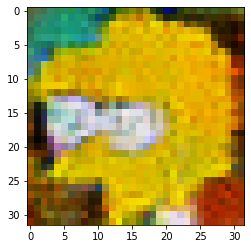

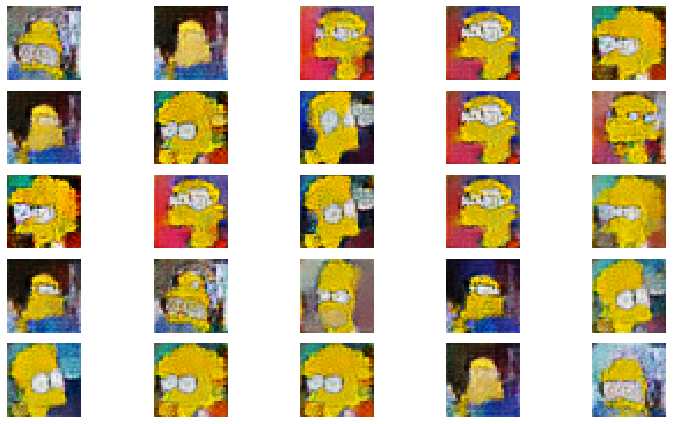

In [93]:
''' lean model @ 85,000-iteration run '''
import numpy as np
from keras.models import load_model

MODEL = './simpsons_models/simpsons_model_42001.h5'

z_noise = np.random.randn(100*25)
z_noise = z_noise.reshape(25, 100)

model = load_model(MODEL)
X = model.predict(z_noise)
X = (X+1) / 2.0

plt.imshow(X[4])

# show multiple designs
shoe_index = 0
fix, ax = plt.subplots(5, 5, figsize=(11, 6), sharey=False, sharex=False)
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(X[shoe_index])
        ax[i, j].axis('off')
        shoe_index += 1
plt.tight_layout()

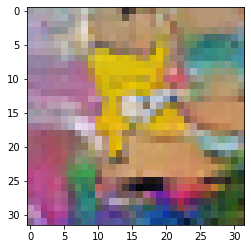

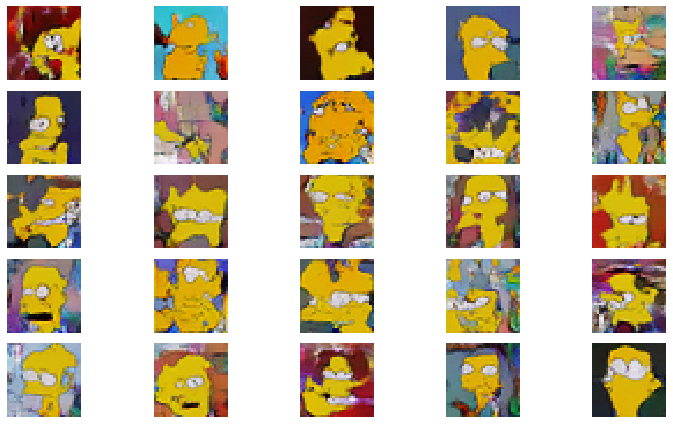

In [95]:
''' shallow model with nested loops @ 180 epochs '''
import numpy as np
from keras.models import load_model

MODEL = '../shoes_dataset/simpsons_models/generator_model_180.h5'

z_noise = np.random.randn(100*25)
z_noise = z_noise.reshape(25, 100)

model = load_model(MODEL)
X = model.predict(z_noise)
X = (X+1) / 2.0

plt.imshow(X[4])

# show multiple designs
shoe_index = 0
fix, ax = plt.subplots(5, 5, figsize=(11, 6), sharey=False, sharex=False)
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(X[shoe_index])
        ax[i, j].axis('off')
        shoe_index += 1
plt.tight_layout()

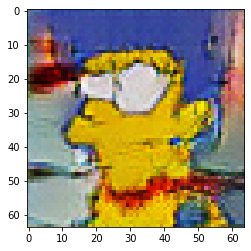

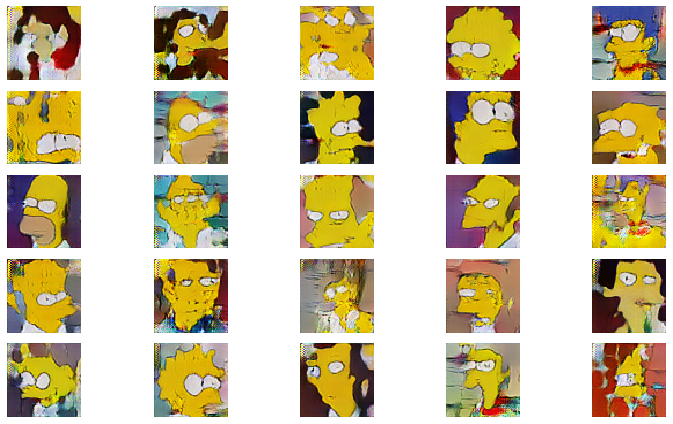

In [94]:
''' deeper model with more filters & nested loops @ 100 epochs '''

MODEL = '../shoes_dataset/simpsons_models/generator_model_100.h5'

z_noise = np.random.randn(100*25)
z_noise = z_noise.reshape(25, 100)

model = load_model(MODEL)
X = model.predict(z_noise)
X = (X+1) / 2.0

plt.imshow(X[4])

# show multiple designs
shoe_index = 0
fix, ax = plt.subplots(5, 5, figsize=(11, 6), sharey=False, sharex=False)
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(X[shoe_index])
        ax[i, j].axis('off')
        shoe_index += 1
plt.tight_layout()